<a href="https://colab.research.google.com/github/Steristell/Capstone/blob/main/cellposeSAM_v5_png.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Documentation: https://github.com/MouseLand/cellpose/blob/main/notebooks/train_Cellpose-SAM.ipynb


Trained on 8 images instead of 3


In [ ]:
!pip install git+https://github.com/MouseLand/cellpose.git

  Cloning https://github.com/MouseLand/cellpose.git to /tmp/pip-req-build-7l4khj1a
  Running command git clone --filter=blob:none --quiet https://github.com/MouseLand/cellpose.git /tmp/pip-req-build-7l4khj1a
  Resolved https://github.com/MouseLand/cellpose.git to commit 6d23968d924fc3b8e419a2d79349888f4b07aa29
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 93.3 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.9.dev5+g6d23968d9-py3-none-any.whl size=212314 sha256=50e5e779e4183b231bf86d7a88b719cae7aea30c2d4db01093b11bb2481191d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-8095j992/wheels/df/58/7b/9c9749ba51886d03da9ee29d2777e4f0fe3365d5bb98000bbd
Successfully built cellpose


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from cellpose import models, core, io, plot, train
from pathlib import Path
import matplotlib.pyplot as plt

io.logger_setup()

if not core.use_gpu():
    raise RuntimeError("No GPU detected. Go to Runtime → Change runtime type → GPU.")

BASE = "/content/drive/My Drive/Colab Notebooks/cellposeSAM"

train_dir = f"{BASE}/train_data"
test_dir  = f"{BASE}/test_data"

if not Path(train_dir).exists():
    raise FileNotFoundError("Training directory not found")

print("Train dir:", train_dir)
print("Test dir:", test_dir)

creating new log file
2026-02-06 03:37:17,054 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2026-02-06 03:37:17,054 [INFO] 
cellpose version: 	4.0.9.dev5+g6d23968d9 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.9.0+cu126
2026-02-06 03:37:17,298 [INFO] ** TORCH CUDA version installed and working. **
Train dir: /content/drive/My Drive/Colab Notebooks/cellposeSAM/train_data
Test dir: /content/drive/My Drive/Colab Notebooks/cellposeSAM/test_data


Points I wanna mention:

* Input format: Segmentation mask 1.1
* Currently: Only tried 3 from web -> need to go to 4-18
* Observations


In [ ]:
from PIL import Image
from glob import glob
import os

for png_path in sorted(glob(f"{train_dir}/*.png")):
    base = os.path.splitext(png_path)[0]          # e.g. ".../1-1"
    tif_path = base + "_masks.tif"                # ".../1-1_masks.tif"

    img = Image.open(png_path)
    img.save(tif_path)
    print("Saved:", os.path.basename(tif_path))

Saved: 1-1_masks.tif
Saved: 1-2_masks.tif
Saved: 1-3_masks.tif
Saved: 1-4_masks.tif
Saved: 1-5_masks.tif
Saved: 1-6_masks.tif
Saved: 1-7_masks.tif
Saved: 1-8_masks.tif


In [ ]:
from cellpose import models

model = models.CellposeModel(
    gpu=True,
    pretrained_model="cyto"   # or "cyto2", "nuclei", etc.
)

2026-02-06 03:37:25,000 [INFO] ** TORCH CUDA version installed and working. **
2026-02-06 03:37:25,001 [INFO] >>>> using GPU (CUDA)
2026-02-06 03:37:25,002 [WARNING] pretrained model /root/.cellpose/models/cpsam not found, using default model
2026-02-06 03:37:27,588 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:11<00:00, 105MB/s] 


In [ ]:
train_imgs = [
    f"{train_dir}/1-1.tif",
    f"{train_dir}/1-2.tif",
    f"{train_dir}/1-3.tif",
    f"{train_dir}/1-4.tif",
    f"{train_dir}/1-5.tif",
    f"{train_dir}/1-6.tif",
    f"{train_dir}/1-7.tif",
    f"{train_dir}/1-8.tif"

]

train_masks = [
    f"{train_dir}/1-1_masks.tif",
    f"{train_dir}/1-2_masks.tif",
    f"{train_dir}/1-3_masks.tif",
    f"{train_dir}/1-4_masks.tif",
    f"{train_dir}/1-5_masks.tif",
    f"{train_dir}/1-6_masks.tif",
    f"{train_dir}/1-7_masks.tif",
    f"{train_dir}/1-8_masks.tif",

]

In [ ]:
from cellpose import io

train_data  = [io.imread(f) for f in train_imgs]
train_labels = [io.imread(f) for f in train_masks]

print("Loaded", len(train_data), "training images.")
print("Image shape:", train_data[0].shape)
print("Mask shape:", train_labels[0].shape)

Loaded 8 training images.
Image shape: (960, 1280, 3)
Mask shape: (960, 1280, 3)


In [ ]:
new_model_path, train_losses, test_losses = train.train_seg(
    model.net,
    train_data=train_data,
    train_labels=train_labels,
    batch_size=1,
    n_epochs=200,
    learning_rate=1e-4,
    weight_decay=1e-5,
    nimg_per_epoch=max(2, len(train_data)),
    model_name="follicle_model_8x",
    min_train_masks=1,
    load_files=False
)

2026-02-06 03:37:49,252 [INFO] >>> converting bfloat16 network to float32 for training
2026-02-06 03:37:49,268 [INFO] flows precomputed
2026-02-06 03:37:49,317 [INFO] >>> computing diameters


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 8/8 [00:00<00:00, 854.28it/s]

2026-02-06 03:37:49,329 [WARNING] 7 train images with number of masks less than min_train_masks (1), removing from train set
2026-02-06 03:37:49,330 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2026-02-06 03:37:49,690 [INFO] >>> n_epochs=200, n_train=1, n_test=None
2026-02-06 03:37:49,690 [INFO] >>> AdamW, learning_rate=0.00010, weight_decay=0.00001
2026-02-06 03:37:49,693 [INFO] >>> saving model to /content/models/follicle_model_8x
2026-02-06 03:37:58,636 [INFO] 0, train_loss=1.2953, test_loss=0.0000, LR=0.000000, time 8.94s
2026-02-06 03:38:34,164 [INFO] 5, train_loss=0.0835, test_loss=0.0000, LR=0.000056, time 44.47s
2026-02-06 03:39:09,903 [INFO] 10, train_loss=9.6875, test_loss=0.0000, LR=0.000100, time 80.21s
2026-02-06 03:40:21,222 [INFO] 20, train_loss=0.0066, test_loss=0.0000, LR=0.000100, time 151.53s
2026-02-06 03:41:33,277 [INFO] 30, train_loss=0.0007, test_loss=0.0000, LR=0.000100, time 223.58s
2026-02-06 03:42:45,049 [INFO] 40, train_loss=0.0003, test_loss=0.0000, LR=0.000100, time 295.36s
2026-02-06 03:43:56,754 [INFO] 50, train_loss=0.0002, test_loss=0.0000, LR=0.000100, time 367.06s
2026-02-06 03:45:08,677 [INFO] 60, train_loss=0.0002, test_loss=0.0000, LR=0.

In [ ]:
from cellpose import models

model = models.CellposeModel(
    gpu=True,
    pretrained_model="/content/models/follicle_model_8x"
)

2026-02-06 04:05:38,644 [INFO] ** TORCH CUDA version installed and working. **
2026-02-06 04:05:38,646 [INFO] >>>> using GPU (CUDA)
2026-02-06 04:05:40,882 [INFO] >>>> loading model /content/models/follicle_model_8x


In [ ]:
os.listdir("/content/models")

['follicle_model_8x']

In [ ]:
import os
os.listdir("/content/models/follicle_model_8x")

NotADirectoryError: [Errno 20] Not a directory: '/content/models/follicle_model_8x'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import io



def predict_mask(model, img_path, diameter=120):
    img = io.imread(img_path)

    masks, flows, styles = model.eval(
        img,
        channels=[0,0],
        diameter=165,          # <-- Adjust the diameter here
        flow_threshold=0.4,
        cellprob_threshold=0.0
    )

    return img, masks

def show_results(img, pred_mask, true_mask=None, title=""):
    plt.figure(figsize=(15,5))

    # raw image
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.axis('off')

    # predicted mask
    plt.subplot(1,3,2)
    plt.imshow(pred_mask, cmap='tab20')
    plt.title("Predicted Mask")
    plt.axis('off')

    # overlay
    plt.subplot(1,3,3)
    overlay = img.copy()
    plt.imshow(img, cmap='gray')
    plt.imshow(pred_mask, cmap='tab20', alpha=0.4)
    plt.title("Overlay")
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

def compute_iou(pred, true):
    pred_bin = pred > 0
    true_bin = true > 0
    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()
    return intersection / union if union > 0 else 0

def compute_dice(pred, true):
    pred_bin = pred > 0
    true_bin = true > 0
    intersection = np.logical_and(pred_bin, true_bin).sum()
    return 2 * intersection / (pred_bin.sum() + true_bin.sum() + 1e-8)

2026-02-06 04:06:23,097 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2026-02-06 04:06:23,103 [INFO] processing image with (1920, 2560) HW, and 3 channels
2026-02-06 04:06:23,270 [INFO] No cell pixels found.


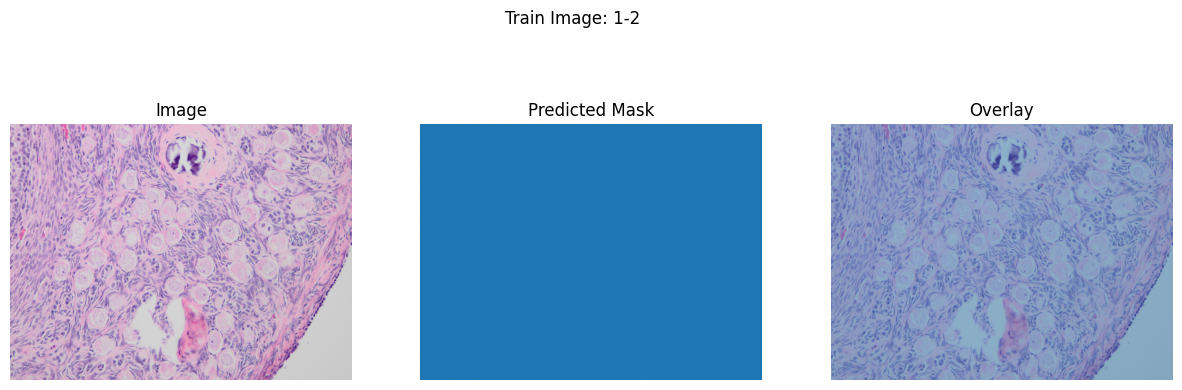

Train IoU: 0.0
Train Dice: 0.0


In [ ]:
# Define training image + mask paths
train_img_path  = f"{train_dir}/1-2.tif"
train_mask_path = f"{train_dir}/1-2_masks.tif"
# train_img_path  = f"{test_dir}/1-18.tif"

def rgb_mask_to_label(mask_rgb):
    """
    Convert CVAT SegmentationObject RGB mask to integer label mask.
    Each unique RGB color becomes a unique integer ID.
    """
    if mask_rgb.ndim == 2:
        return mask_rgb  # already single-channel

    h, w, _ = mask_rgb.shape
    mask_flat = mask_rgb.reshape(-1, 3)

    unique_colors, inverse = np.unique(mask_flat, axis=0, return_inverse=True)
    label_mask = inverse.reshape(h, w).astype(np.int32)

    return label_mask

from skimage import io as skio

# Load image + prediction
img, pred = predict_mask(model, train_img_path)

# Load ground truth (RGB) and convert to integer labels
true_rgb = skio.imread(train_mask_path)
true = rgb_mask_to_label(true_rgb)

# Visualize
show_results(img, pred, true_mask=true, title="Train Image: 1-2")

# Metrics
iou = compute_iou(pred, true)
dice = compute_dice(pred, true)

print("Train IoU:", iou)
print("Train Dice:", dice)

IoU = how much the predicted mask overlap with true mask = overlap area/ area of union

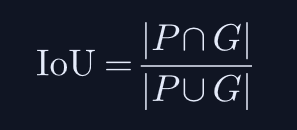



Dice = how similar the predicted & true masks are = (2 * overlap)/ (size of prediction/ size of ground truth)
(usually 0.7 is good in biomed tasks)

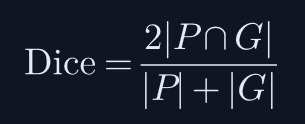

* The model is capturing the general shape
* The model is capturing the general location
* The model is not perfect on boundaries
* The model is slightly off in size or alignment
* The model is much better than before

Dice is higher because shapes are similar, even if not perfectly overlapping.
IoU is lower because the boundaries and alignment aren’t perfect yet.

What to improve next
To raise both IoU and Dice:
- Add more training images
- Tune diameter ± 20 px
- Add augmentation
- Train longer
- Improve boundary learning

# why not matching 100%?
Cellpose doesn’t predict masks directly.
It predicts:
- flow fields
- cell probability maps
- gradients
- vector directions

Then it reconstructs masks from those flows.
This reconstruction step is not invertible — meaning:
Even if  gave Cellpose the exact ground‑truth mask, it would not reproduce it pixel‑perfectly.



In [ ]:
print("Pred unique:", np.unique(pred))
print("True unique:", np.unique(true))
print("Pred shape:", pred.shape)
print("True shape:", true.shape)

Pred unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
True unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Pred shape: (1920, 2560)
True shape: (1920, 2560)


Now compare against others

2026-02-06 04:06:33,554 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2026-02-06 04:06:33,556 [INFO] processing image with (960, 1280) HW, and 3 channels
2026-02-06 04:06:33,610 [INFO] No cell pixels found.


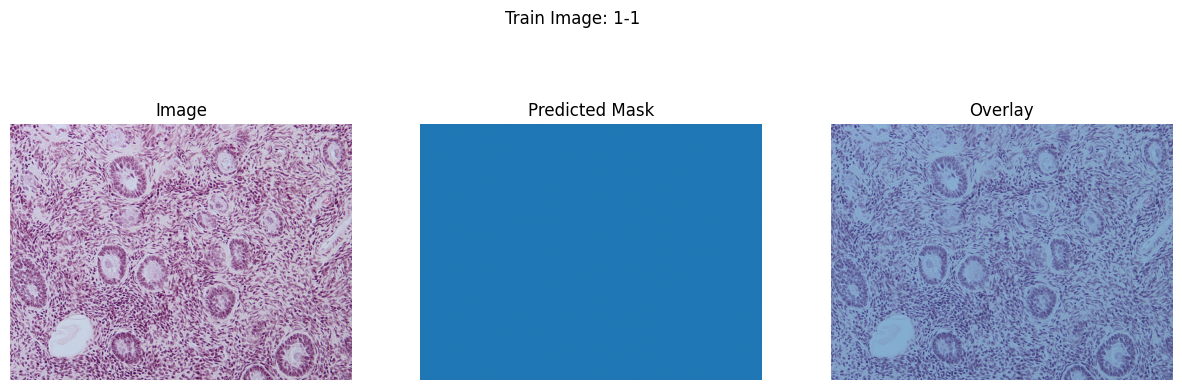

Train IoU: 0.0
Train Dice: 0.0


In [ ]:
# Define training image + mask paths
train_img_path  = f"{train_dir}/1-1.tif"
train_mask_path = f"{train_dir}/1-1_masks.tif"
# train_img_path  = f"{test_dir}/1-18.tif"

def rgb_mask_to_label(mask_rgb):
    """
    Convert CVAT SegmentationObject RGB mask to integer label mask.
    Each unique RGB color becomes a unique integer ID.
    """
    if mask_rgb.ndim == 2:
        return mask_rgb  # already single-channel

    h, w, _ = mask_rgb.shape
    mask_flat = mask_rgb.reshape(-1, 3)

    unique_colors, inverse = np.unique(mask_flat, axis=0, return_inverse=True)
    label_mask = inverse.reshape(h, w).astype(np.int32)

    return label_mask

from skimage import io as skio

# Load image + prediction
img, pred = predict_mask(model, train_img_path, diameter = 70) #If I let the diameter be 120, none is found!

# Load ground truth (RGB) and convert to integer labels
true_rgb = skio.imread(train_mask_path)
true = rgb_mask_to_label(true_rgb)

# Visualize
show_results(img, pred, true_mask=true, title="Train Image: 1-1")

# Metrics
iou = compute_iou(pred, true)
dice = compute_dice(pred, true)

print("Train IoU:", iou)
print("Train Dice:", dice)

In [ ]:
print("Pred unique:", np.unique(pred))
print("True unique:", np.unique(true))
print("Pred shape:", pred.shape)
print("True shape:", true.shape)

Pred unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
True unique: [0 1 2]
Pred shape: (960, 1280)
True shape: (960, 1280)


2026-02-06 04:06:36,289 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2026-02-06 04:06:36,292 [INFO] processing image with (1024, 1360) HW, and 3 channels
2026-02-06 04:06:36,358 [INFO] No cell pixels found.


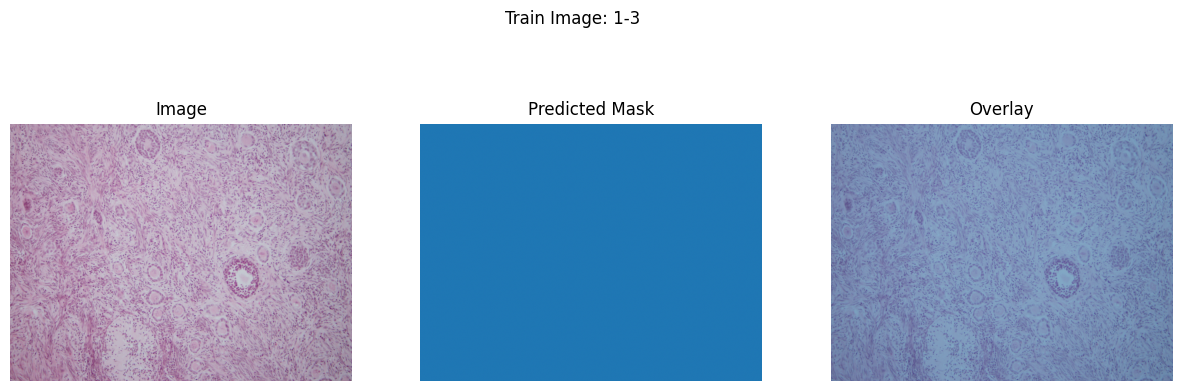

Train IoU: 0.0
Train Dice: 0.0


In [ ]:
# Define training image + mask paths
train_img_path  = f"{train_dir}/1-3.tif"
train_mask_path = f"{train_dir}/1-3_masks.tif"
# train_img_path  = f"{test_dir}/1-18.tif"

def rgb_mask_to_label(mask_rgb):
    """
    Convert CVAT SegmentationObject RGB mask to integer label mask.
    Each unique RGB color becomes a unique integer ID.
    """
    if mask_rgb.ndim == 2:
        return mask_rgb  # already single-channel

    h, w, _ = mask_rgb.shape
    mask_flat = mask_rgb.reshape(-1, 3)

    unique_colors, inverse = np.unique(mask_flat, axis=0, return_inverse=True)
    label_mask = inverse.reshape(h, w).astype(np.int32)

    return label_mask

from skimage import io as skio

# Load image + prediction
img, pred = predict_mask(model, train_img_path, diameter = 55) #If I let the diameter be 120, none is found!

# Load ground truth (RGB) and convert to integer labels
true_rgb = skio.imread(train_mask_path)
true = rgb_mask_to_label(true_rgb)

# Visualize
show_results(img, pred, true_mask=true, title="Train Image: 1-3")

# Metrics
iou = compute_iou(pred, true)
dice = compute_dice(pred, true)

print("Train IoU:", iou)
print("Train Dice:", dice)

In [ ]:
print("Pred unique:", np.unique(pred))
print("True unique:", np.unique(true))
print("Pred shape:", pred.shape)
print("True shape:", true.shape)

Pred unique: [0]
True unique: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Pred shape: (1024, 1360)
True shape: (1024, 1360)


2026-02-06 04:16:17,782 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2026-02-06 04:16:17,788 [INFO] processing image with (1920, 2560) HW, and 3 channels
2026-02-06 04:16:17,958 [INFO] No cell pixels found.


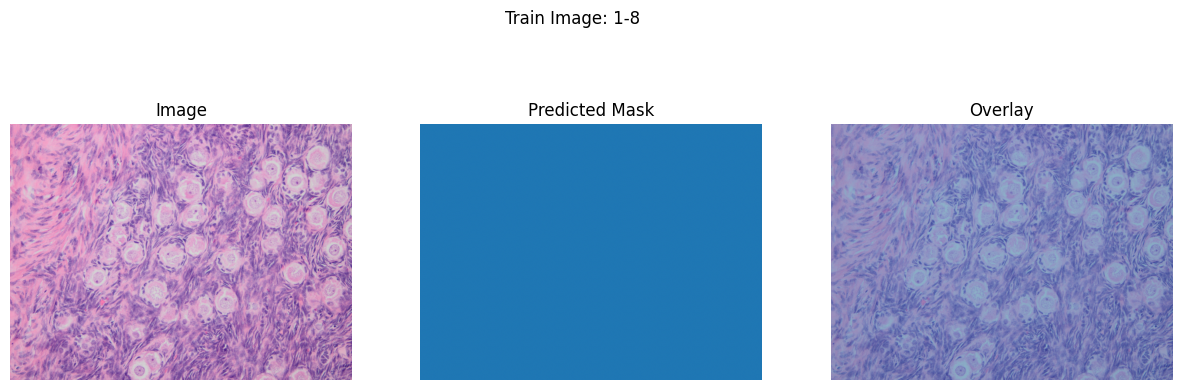

Train IoU: 0.0
Train Dice: 0.0


In [ ]:
# Define training image + mask paths
train_img_path  = f"{train_dir}/1-8.tif"
train_mask_path = f"{train_dir}/1-8_masks.tif"
# train_img_path  = f"{test_dir}/1-18.tif"

def rgb_mask_to_label(mask_rgb):
    """
    Convert CVAT SegmentationObject RGB mask to integer label mask.
    Each unique RGB color becomes a unique integer ID.
    """
    if mask_rgb.ndim == 2:
        return mask_rgb  # already single-channel

    h, w, _ = mask_rgb.shape
    mask_flat = mask_rgb.reshape(-1, 3)

    unique_colors, inverse = np.unique(mask_flat, axis=0, return_inverse=True)
    label_mask = inverse.reshape(h, w).astype(np.int32)

    return label_mask

from skimage import io as skio

# Load image + prediction
img, pred = predict_mask(model, train_img_path, diameter = 180) #If I let the diameter be 120, none is found!

# Load ground truth (RGB) and convert to integer labels
true_rgb = skio.imread(train_mask_path)
true = rgb_mask_to_label(true_rgb)

# Visualize
show_results(img, pred, true_mask=true, title="Train Image: 1-8")

# Metrics
iou = compute_iou(pred, true)
dice = compute_dice(pred, true)

print("Train IoU:", iou)
print("Train Dice:", dice)

In [ ]:
print("Pred unique:", np.unique(pred))
print("True unique:", np.unique(true))
print("Pred shape:", pred.shape)
print("True shape:", true.shape)

Pred unique: [0]
True unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Pred shape: (1920, 2560)
True shape: (1920, 2560)


FINDING BEST DIAMETER (commeting cuz only need to be done once!)

In [ ]:
import numpy as np
from skimage import measure, io as skio

mask_rgb = skio.imread(f"{train_dir}/1-8.png")
mask = rgb_mask_to_label(mask_rgb)   # your converter

regions = measure.regionprops(mask)

sizes = []
for r in regions:
    # approximate "diameter" as mean of minor/major axis
    d = 0.5 * (r.minor_axis_length + r.major_axis_length)
    sizes.append(d)

print("Approx diameters (px):", sizes)
print("Mean diameter:", np.mean(sizes))
print("Median diameter:", np.median(sizes))

Approx diameters (px): [182.7817286473438, 182.94595059215948, 192.7374330063967, 171.83218550454203, 207.95848810676094, 173.86455880955978, 159.16930004708368, 202.74901180667786, 191.65184693078675, 166.85367186934027, 205.89359702734214, 195.67375150615908, 175.76025716501312, 189.97681652470624, 187.84202811565183, 162.87452164550336, 147.78663250873495, 208.8509376837511, 185.9569301846073, 198.93604735406382, 188.9057163598306, 168.8634163831593]
Mean diameter: 184.08476489905334
Median diameter: 186.89947915012957


1-1: 75
1-2: 120
1-3: 60